# CSC_52081_EP_TP1

## Introduction

File may be found in: [https://www.lix.polytechnique.fr/~jread](https://www.lix.polytechnique.fr/~jread/courses/inf581/labs/01/).

### Main Objectives

Intelligent decision making involves several components. In the context of a low-dimensional and synthetic toy:

- **perception**: observation;
- **knowledge**: representation;
- **reasoning**: inference;
- **acting**: decision-making;

The objective is to design a rational / intelligent agent, i.e., an agent that maximizes its expected reward.

### Imports

Make sure the `environment.py` is in your working directory.

In [1]:
# if you are using Google Colab, uncomment the following line (comment again when you have run it)
# !wget https://www.lix.polytechnique.fr/~jread/courses/inf581/labs/01/environment.py

from environment import Environment

import numpy as np
import matplotlib.pyplot as plt

## Environment

Consider an intelligent agent as a robot tasked with catching rats in a storage room. It is night time, and the room is dark. You have to rely on auditory information only, but luckily the room is a mess with paper and other debris that means there are distinct sounds which are emitted by a rat as it touches different objects (namely, crinkling and rustling sounds).

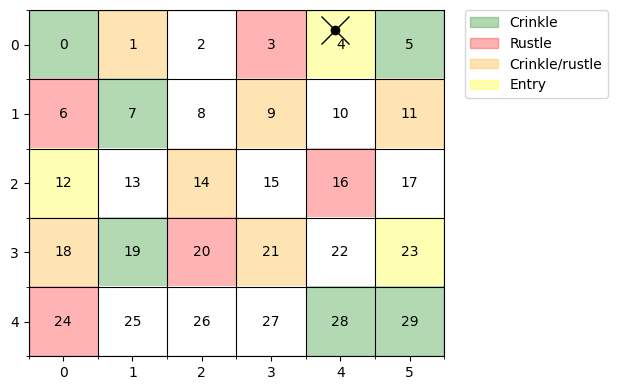

In [ ]:
# grid position colors
#   1: crinkle
#   2: rustle
#   3: crinkle and rustle
#   4: entry

grid = np.array([
    [1, 3, 0, 2, 4, 1],
    [2, 1, 0, 3, 0, 3],
    [4, 0, 3, 0, 2, 0],
    [3, 1, 2, 3, 0, 4],
    [2, 0, 0, 0, 1, 1]
])

env = Environment(grid)

# environment at state 's_t = 4'
fig, ax = env.render([4], None)
plt.show()

The room is rectangular, divided up into $n$ square tiles. A rat has just entered the room at current time $t=1$. The agent waits $T$ seconds (i.e., until $t=T$), then makes a decision on if and where to pounce (in order to catch the rat).

Insofar as the observation function: 

- **crinkle**: is generated with probability $\theta_1$ over certain tiles, green or orange, and $0$ otherwise;
- **rustling** is generated with probability $\theta_2$ over certain tiles, red or orange, and $0$ otherwise;

On orange tiles, both noises are caused independently of each other.

### `env.step()`

You should be able to see by looking at the code, that the rat moves by exactly $1$ square tile, either horizontally or vertically (i.e., taxicab-distance) per time step $t$, within the bounds of the room, starting at one of the entry points (uniformly at random).

### Notation

#### $s_{t}$, position states

$s_t \in \{1,\ldots,n\}$ denote the state of the rat, it's position, at time step $t$ starting at some $s_1$, called entry tile.

The Environment is fully specified for you, as a Markov process:
$$
    s_{t+1} \sim p(\cdot | s_t)
$$

#### $\mathbf{x}_t$, observation

$\mathbf{x}_t \in \{0,1\}^2$ is the 2-dimensional auditory observation at time $t$. An array of observations is denoted as $\mathbf{x}_{1:T} = \mathbf{x}_1,\ldots,\mathbf{x}_T$.

e.g.: $\mathbf{x}_t = [1,0]$ if there is a crinkle but no rustle.

The Environment is fully specified for you, as a Markov process:
$$
    \mathbf{x}_t \sim p( \cdot | s_t)
$$

### Agent

The agent accumulates a sequence of **observations** with which to make the decision of taking **action** $a$ to pounce, position state where the rat is.

The agent obtains **reward** $r(s, a) = 1_{s = a}$, i.e., catching the rat provides reward $1$ and $0$ otherwise.

As an influence diagram, the problem described can be depicted as follows:

![pgm](https://www.lix.polytechnique.fr/~jread/courses/inf581/labs/01/fig/pgm.png)

Your task is to model this problem in Python code. Finally, the goal is to implement an `Agent` which will provide the best action $a$ (according to current knowledge, i.e., given observation sequence $\mathbf{x}_{1:T}$) and associated uncertainty.

**Beware** of the potential confusion here: $s_T$ represents the state of the environment but decision making, choosing action $a$, is based on observation $o = \mathbf{x}_{1:T}$.

The Agent is responsible for receiving observation $o = \mathbf{x}_{1:T}$ and producing prediction $a$, i.e., it implements $a = \pi(o)$, i.e., its policy or `act` function as it is called here below. But let's implement the functionality step by step. 

Your agent has observed evidence $\mathbf{x}_1,\ldots,\mathbf{x}_T$, and queried the model, according to your beliefs (environment dynamics). Time to make a decision. Which action to take? The answer: 
$$
    a_* = \text{argmax}_a \mathbb{E}_{S_T \sim P(S_T | \mathbf{x}_{1:T})}[ r(S_T, a) ]
$$

Note your uncertainty about the final state $S_T$. 

In this scenario the action does not affect future observations (because $s_T$ is the final observation), thus you are essentially making an estimate:
$$
    a = \hat s_{T} = \pi(\mathbf{x}_{1:T})
$$

## Part I. `generate_trajectory()`

In [3]:
def generate_trajectory(env, T:int = 5) -> tuple[np.ndarray[float], np.ndarray[float]]:
    '''
    Generate a random path of length T with associated observations.

    Parameters
    ----------

        T (int): path length

    Returns
    -------

        o (np.ndarray): Tx2 array of observations
        s (np.ndarray): Tx1 array of states
    '''
    s = np.zeros(T, dtype=int)
    o = np.zeros((T, 2), dtype=int)

    s[0], o[0] = env.step()

    for t in range(1, T):
        s_t, o_t = env.step(s[t-1])

        s[t] = s_t
        o[t] = o_t

    return o, s

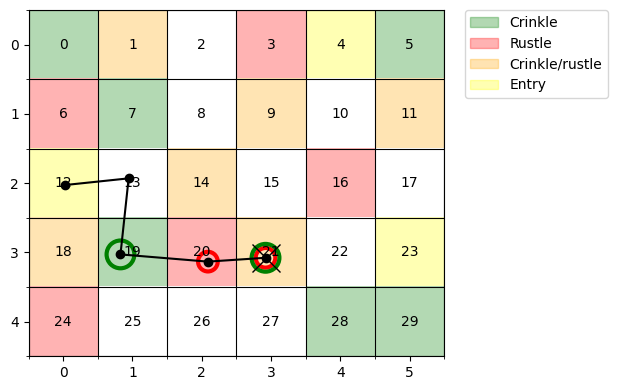

In [ ]:
# generate and view trajectory
observations, states = generate_trajectory(env, 5)
fig, ax = env.render(states, observations)

# observations:
#   red circle: rustle detected
#   green circle: crinkle detected

plt.show()

It is important to realize that although we can have full access to the environment, as well as observations, we do not expect in the 'real world' to see the true path $s_1,\ldots,s_T$ and hence the challenge in estimating $s_T$. For this we will create an `Agent` class.

In [5]:
class Agent:
    def __init__(self, env: Environment) -> None:
        '''
        Parameters
        ----------
            env (Environment): environment provided
        '''
        self.env = env


    def P_trajectories(self, observations: np.ndarray[float], M: int = -1) -> dict:
        '''
        Provides full conditional distribution P(states | observations) where states and
        observations are sequences of length T.

        Parameters
        ----------
            observations (np.ndarray[float]): Tx2 sequence of observations of dimension.

            M (int, optional) : computation method:

                -1: use Brute Force solution
                >0: use M Monte Carlo simulations 

        Returns
        -------
            p (dict[str: float]) : probability distribution p[states] = P(states | observations).
        '''
        p: dict = {}
        rustle: int = 1
        crinkle: int = 0

        # Exact Recovery with brute force
        if M == -1:
            def generate_paths(current_path, current_probability, step):
                """Recursive helper function to generate all paths."""
                if step == len(observations):
                    path: str = " ".join(map(str, current_path))
                    p[path] = current_probability

                    return

                current_state: int = current_path[-1]

                for next_state in range(self.env.n_states):
                    transition_probability: float = self.env.P_S[current_state, next_state]

                    if transition_probability != 0:
                        noise_probability: float  = (
                            self.env.P_O[next_state, rustle, observations[step][rustle]]
                            * self.env.P_O[next_state, crinkle, observations[step][crinkle]]
                        )

                        generate_paths(
                            current_path + [next_state],
                            current_probability * transition_probability * noise_probability,
                            step + 1,
                        )


            for initial_state in range(self.env.n_states):
                initial_probability: float = self.env.P_1[initial_state]

                if initial_probability != 0:
                    generate_paths([initial_state], initial_probability, 1)

            total_probability: float = sum(p.values())
            if total_probability > 0:
                p = {k: v / total_probability for k, v in p.items() if v > 0.0}


        # Monte Carlo simulation
        elif M > 0:
            for _ in range(M):
                initial_state: int = np.random.choice(self.env.n_states, p=self.env.P_1)

                current_path: list = [initial_state]
                current_probability: float = self.env.P_1[initial_state]

                for step in range(len(observations)):
                    current_state: int = current_path[-1]

                    next_state: int = np.random.choice(
                        self.env.n_states,
                        p = self.env.P_S[current_state]
                    )

                    transition_probability: float = self.env.P_S[current_state, next_state]

                    noise_probability: float = (
                        self.env.P_O[next_state, rustle, observations[step][rustle]] *
                        self.env.P_O[next_state, crinkle, observations[step][crinkle]]
                    )

                    current_path.append(next_state)
                    current_probability *= transition_probability * noise_probability

                path: str = " ".join(map(str, current_path))
                if path in p:
                    p[path] += current_probability
                else:
                    p[path] = current_probability

            total_probability: float = sum(p.values())
            if total_probability > 0:
                p = {k: v / total_probability for k, v in p.items() if v > 0.0}

        return p


    def P_states(
            self, observations: np.ndarray[float], instant: int = -1, M: int = -1
        ) -> list[float]:
        '''
        Provide P(state_t | observations) given observations o from 1,...,T.

        Parameters
        ----------

            observations (np.ndarray[float]): Tx2 sequence of observations of dimension.
            instant (int, optional): instant of observations. Default is '-1', last instant.
            M (int, optional) : computation method. Default is '-1'.
                -1: use Brute Force solution
                >0: use M Monte Carlo simulations 

        Returns
        -------

            P_states (list[float]) : probability distribution p[states] = P(states | observations).
        '''
        P_states: dict = {state: 0 for state in range(self.env.n_states)}

        if instant <= -1 or instant >= len(observations):
            instant = len(observations) - 1

        next_instant:int = instant + 1


        P_trajectories: dict = self.P_trajectories(observations[:next_instant, :], M)

        for trajectory, probability in P_trajectories.items():
            P_states[int(trajectory.split(" ")[instant])] += probability

        total_probability: float = sum(P_states.values())
        if total_probability > 0:
            P_states = {k: v / total_probability for k, v in P_states.items()}

        return np.array(list(P_states.values()))


    def Q_values(
            self, observations: np.ndarray[float], instant: int = -1, M: int = -1
        ) -> np.ndarray[float]:
        '''
        Provide expected reward for an action given an array of observations.

        Parameters
        ----------

            observations (np.ndarray[float]): Tx2 sequence of observations of dimension.
            instant (int, optional): instant of observations. Default is '-1', last instant.
            M (int, optional) : computation method. Default is '-1'.
                -1: use Brute Force solution
                >0: use M Monte Carlo simulations

        Returns
        -------

            Q_states (np.ndarray[float]) : expected reward for an action given observations.
        '''
        Q_values: np.ndarray = np.zeros(self.env.n_states)

        P_states = self.P_states(observations, instant, M)

        maximum_probability = np.max(P_states)
        for i, state_probability in enumerate(P_states):
            if state_probability == maximum_probability:
                Q_values[i] = 1

        return Q_values

    def action(
            self, observations: np.ndarray[float], instant: int = -1, M: int = -1
        ):
        '''
        Decide on the best action to take, under the provided observation. 

        Parameters
        ----------

            observations (np.ndarray[float]): Tx2 sequence of observations of dimension.
            instant (int, optional): instant of observations. Default is '-1', last instant.
            M (int, optional) : computation method. Default is '-1'.
                -1: use Brute Force solution
                >0: use M Monte Carlo simulations

        Returns
        -------

            bast action to take.
        '''
        Q_values = self.Q_values(observations, instant, M)

        possible_actions = []

        maximum_probability = np.max(Q_values)
        for i, state_probability in enumerate(Q_values):
            if state_probability == maximum_probability:
                possible_actions.append(i)

        return np.random.choice(possible_actions)


In [17]:
agent = Agent(env)

## Part II. `agent.P_trajectories(M=-1)`

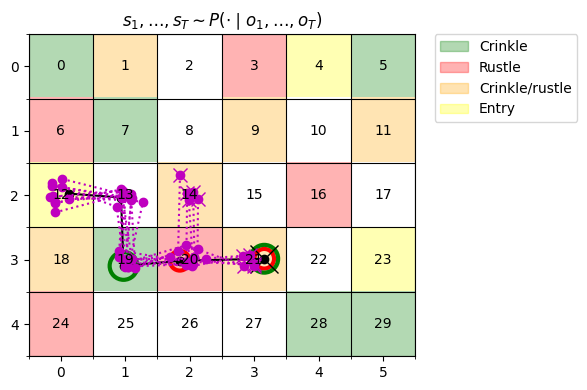

In [7]:
P_trajectories = agent.P_trajectories(observations)

probabilities = list(P_trajectories.values())
assert abs(sum(probabilities) - 1) <= 0.05

paths = [np.fromstring(k, sep=' ') for k in P_trajectories.keys()] 

sample_indices = np.random.choice(len(probabilities), size=10, p=probabilities)
trajectories = [paths[i].astype(int) for i in sample_indices]


fig, ax = env.render(states, observations, paths=trajectories, title=r"$s_1,\ldots,s_T \sim P(\cdot \mid o_1,\ldots,o_T)$")
plt.show()

## Part III. `P_states()`

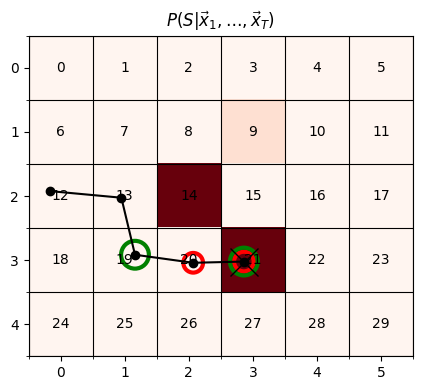

In [10]:
P_states = agent.P_states(observations, 4)

fig, ax = env.render(states, observations, dgrid=P_states, title=r"$P(S | \vec{x}_1,\ldots,\vec{x}_T)$")
plt.show()

## Part IV. `Q_values()`

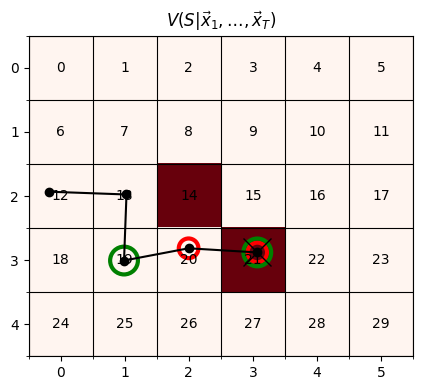

In [11]:
Q_values = agent.Q_values(observations)

fig, ax = env.render(states, observations, dgrid=Q_values, title=r"$V(S | \vec{x}_1,\ldots,\vec{x}_T)$")
plt.show()

## Part V. `action()`

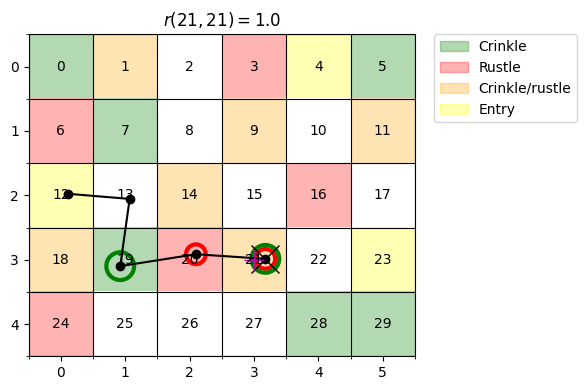

In [ ]:
s_T = states[-1]
a = agent.action(observations)


r = env.rwd(s_T,a)
fig, ax = env.render(states, observations, a_star=a, title="$r(%d,%d) = %2.1f$" % (s_T,a,r))

### Answer

Reward is not maximum because in same cases may actions may be possible with equal probability. In this case, agent will randomly choose action.

### Analysis

In [16]:
n = 100
reward_average = 0

for i in range(n): 
    observations, states = generate_trajectory(env,5)
    action = agent.action(observations)
    reward_average += env.rwd(states[-1], action) / n

print(f'[{n:04d}]\taverage reward: {reward_average:.4f} in [0, 1]')

[0100]	average reward: 0.5900 in [0, 1]


## Conclusion

This was just a toy example, but consider the fundamental concepts here (we will be using them again); we designed an intelligent decision-making agent involving *perception* (observation), *knowledge* (representation), *reasoning* (inference), and *acting* (decision-making).

There are two limitations here: the toy nature of the environment (maybe your solution does not scale up to large $d$ or large $T$) and the requirement for a hand-coded environment.

Next week we will look at efficient inference, and learning (including, representation learning) which allows to overcome these limitations; toward not only an autonomous agent, but a capable and scalable autonomous agent.